In [1]:
#%pip install torch torchvision torchaudio
#%pip install scipy
#%pip install torch
#%pip install pyinform

import pandas as pd
import numpy as np
from binance.client import Client
import kagglehub
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import torch
from datetime import datetime, timedelta
import yfinance as yf
from transformers import pipeline
from pyinform.transferentropy import transfer_entropy
from joblib import Parallel, delayed
import time
from arch import arch_model
import statsmodels.api as sm

from utils.calibration import *
from utils.helpers import *

c:\Users\Mert\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\Mert\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
#Sentiment classification
#Defined for sentiment classification
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Downloading Elon Musk Tweets

Get the TSLA news data

In [141]:
tsla_news = read_file("../data/raw/TSLA_news.parquet")
tsla_news.head()

,Date,Stock_symbol,Article_title
0,2023-12-16 22:00:00,TSLA,Scotiabank's Mexico bet eyeing $1.6 trillion N...
1,2023-12-16 20:00:00,TSLA,Can the 'Magnificent Seven' Continue to Lead t...
2,2023-12-16 20:00:00,TSLA,"Notable ETF Outflow Detected - IWB, TSLA, LLY,..."
3,2023-12-16 20:00:00,TSLA,"Swedes support Tesla mechanics' strike, poll s..."
4,2023-12-16 20:00:00,TSLA,"Some Potential 2024 Winners Reside in QQQ, QQQM"


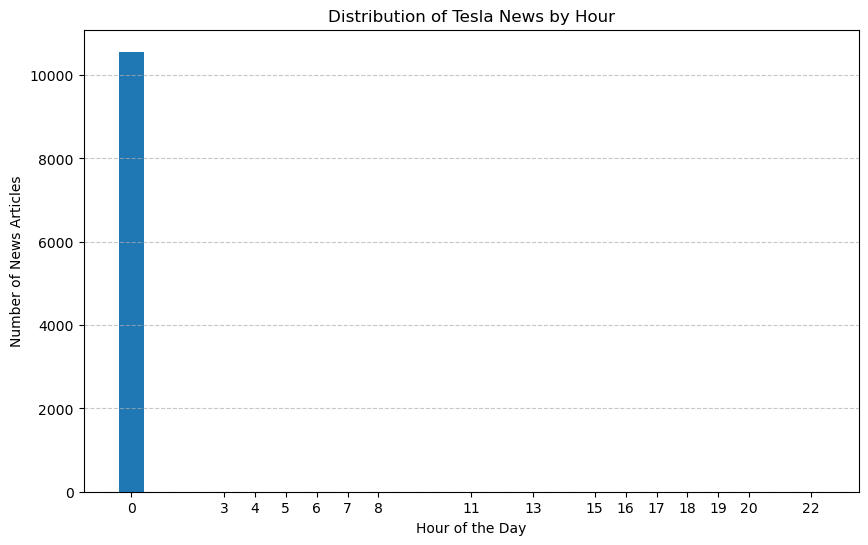

In [142]:
# Assuming `tsla_news` is your DataFrame and `Date` is a datetime column
# Extract the hour from the Date column
hour_counts = pd.DataFrame(tsla_news["Date"].apply(lambda val: val.hour)).value_counts().sort_index()

# Convert the result into a proper DataFrame
hour_counts = hour_counts.reset_index()
hour_counts.columns = ['Hour', 'Count']

# Sort the DataFrame by Hour
hour_counts = hour_counts.sort_values(by='Hour')

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(hour_counts['Hour'], hour_counts['Count'])
plt.xlabel('Hour of the Day')
plt.ylabel('Number of News Articles')
plt.title('Distribution of Tesla News by Hour')
plt.xticks(hour_counts['Hour'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [143]:
#Sentiment Analysis on Tesla Stock"
tqdm.pandas()
tsla_news['Sentiment'] = tsla_news['Article_title'].progress_apply(distill_roberta_classify_sentiment)

100%|██████████| 10587/10587 [04:54<00:00, 35.97it/s]


In [144]:
#Preprocess and write the file
tsla_news = tsla_news.rename({"Date":"date","Article_title":"text"}, axis = 1).filter(["date","text","Sentiment"])
tsla_news["date"] = tsla_news["date"].apply(lambda val: pd.to_datetime(val))

#Writing the file
write_file(tsla_news,"../data/clean/tsla_news_with_sent.csv")

Get the Tesla Quotes

In [10]:
def get_tesla_stock_data(start_date: str, end_date: str = None) -> pd.DataFrame:

    # Define the ticker symbol for Tesla
    ticker_symbol = "TSLA"

    # Fetch data using yfinance
    tesla_data = yf.download(ticker_symbol, start=start_date, end=end_date)

    # Ensure the Date column is part of the DataFrame
    tesla_data.reset_index(inplace=True)

    return tesla_data

In [ ]:
# Example usage
start_date = "2019-07-01"
end_date = "2023-12-31"
tesla_stock_data = get_tesla_stock_data(start_date, end_date)

# Display the data
tesla_stock_data.head()

In [ ]:
get_stock_price_data(ticker_symbol = "TSLA",start_date="2019-07-01", end_date = "2023-12-31")

In [ ]:
#Preprocess and writing the Tesla Quotes
tesla_stock_data["Date"] = tesla_stock_data["Date"].apply(lambda val:pd.to_datetime(val))

#Writing the file
write_file(tesla_stock_data,"./data/clean/tesla_quotes.csv")

Get the Elon Musk Tweets

In [30]:
tweet_df = read_file("../data/raw/elon_musk_tweets.csv")
tweet_df = tweet_df.filter(["date", "text"])
tweet_df.head()

,date,text
0,2022-07-05 17:55:09+00:00,@BillyM2k I find the gold toe sock – inevitabl...
1,2022-07-05 17:47:42+00:00,"Sock Con, the conference for socks"
2,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...
3,2022-07-05 17:40:05+00:00,@ExplainThisBob This guy gets it
4,2022-07-05 17:38:23+00:00,Sock tech is so advanced that you can get pret...


Sentiment Analysis for Elon's tweets

In [47]:
tqdm.pandas()
tweet_df['Sentiment'] = tweet_df['text'].progress_apply(distill_roberta_classify_sentiment)


100%|██████████| 5904/5904 [03:08<00:00, 31.28it/s]


Sentiment Scores for Elon Tweets

In [49]:
tweet_df = read_file("../data/processed/elon_tweet_sentiment.csv")

# Convert 'date' column to datetime format
tweet_df['date'] = pd.to_datetime(tweet_df['date'])

# Sort DataFrame by datetime
tweet_df = tweet_df.sort_values(by='date', ascending=True).reset_index(drop=True)

tweet_df.head()

,date,text,Sentiment
0,2022-07-05 13:46:20+00:00,@historydefined While bleak posts maybe genera...,1
1,2022-07-05 14:00:21+00:00,@TonyadeVitti @historydefined His success was ...,1
2,2022-07-05 14:42:21+00:00,@slashdot It’s time,0
3,2022-07-05 17:36:03+00:00,I must confess to a penchant for creative socks,0
4,2022-07-05 17:38:23+00:00,Sock tech is so advanced that you can get pret...,0


In [85]:
write_file(tweet_df,"../data/clean/musk_tweets_with_sent.csv")

Getting the dogecoin price data

In [30]:
from utils.constants import Constant
C= Constant()

In [ ]:
# Example usage
df_doge = fetch_coin_data_from_binance(
    api_key=C.API_KEY,
    api_secret=C.API_SECRET,
    start_date="4 Nov, 2021", #Start date of the Crypto News
    end_date="31 Dec, 2023"
)

#Preprocess the Dogecoin price data
df_doge = (
            df_doge.filter(["time_open", "Open"])
                  .rename({"time_open":"Date"}, axis = 1)
                  )

df_doge["Date"] = df_doge["Date"].apply(lambda val: pd.to_datetime(val))

In [34]:
df_doge.head()

,Date,Open
0,2021-11-04 00:00:00+00:00,0.2689
1,2021-11-04 00:01:00+00:00,0.2691
2,2021-11-04 00:02:00+00:00,0.2697
3,2021-11-04 00:03:00+00:00,0.2698
4,2021-11-04 00:04:00+00:00,0.2695


In [35]:
#Write the cleaned dataset
write_file(df_doge, "./data/clean/doge_price.parquet")

Get the crypto market news data

In [80]:
crypto_market_news_df = read_file("../data/raw/crypto_news.csv")
#First we get the date and the text and then we filter the subject as "altcoin" as Dogecoin is an altcoin
filtered_news_df = crypto_market_news_df[crypto_market_news_df["subject"] == "altcoin"].filter(["date","text"])
filtered_news_df.head()

,date,text
0,2023-12-19 06:40:41,Grayscale CEO Michael Sonnenshein believes the...
10,2023-12-18 23:48:19,"The new CEO, Josh Swihart, has been the vice p..."
13,2023-12-18 22:48:00,Tether asserts to have effectively immobilized...
14,2023-12-18 21:47:07,Here is our weekly collection of digital asset...
16,2023-12-18 20:56:00,BEEG's adoption skyrockets as 37% is minted wi...


In [91]:
tqdm.pandas()
filtered_news_df['Sentiment'] = filtered_news_df['text'].progress_apply(distill_roberta_classify_sentiment)

100%|██████████| 9278/9278 [06:06<00:00, 25.32it/s]


In [ ]:
#Preprocessing the crypto news data
filtered_news_df["date"] = filtered_news_df["date"].apply(lambda val: pd.to_datetime(val))

#Writing the file
write_file(filtered_news_df, "../data/clean/crypto_news_with_sent.csv")

Merging the dataframes

In [119]:
filtered_news_df.head(), filtered_news_df.shape

(                  date                                               text  \
 0  2023-12-19 06:40:41  Grayscale CEO Michael Sonnenshein believes the...   
 10 2023-12-18 23:48:19  The new CEO, Josh Swihart, has been the vice p...   
 13 2023-12-18 22:48:00  Tether asserts to have effectively immobilized...   
 14 2023-12-18 21:47:07  Here is our weekly collection of digital asset...   
 16 2023-12-18 20:56:00  BEEG's adoption skyrockets as 37% is minted wi...   
 
     Sentiment  
 0           0  
 10          0  
 13          0  
 14          0  
 16          1  ,
 (9278, 3))

In [120]:
tweet_df.head(),tweet_df.shape

(                 date                                               text  \
 0 2022-07-05 13:46:20  @historydefined While bleak posts maybe genera...   
 1 2022-07-05 14:00:21  @TonyadeVitti @historydefined His success was ...   
 2 2022-07-05 14:42:21                                @slashdot It’s time   
 3 2022-07-05 17:36:03    I must confess to a penchant for creative socks   
 4 2022-07-05 17:38:23  Sock tech is so advanced that you can get pret...   
 
    Sentiment  
 0          1  
 1          1  
 2          0  
 3          0  
 4          0  ,
 (5904, 3))

In [149]:
tsla_news.head(),tsla_news.shape

(                 date                                               text  \
 0 2023-12-16 22:00:00  Scotiabank's Mexico bet eyeing $1.6 trillion N...   
 1 2023-12-16 20:00:00  Can the 'Magnificent Seven' Continue to Lead t...   
 2 2023-12-16 20:00:00  Notable ETF Outflow Detected - IWB, TSLA, LLY,...   
 3 2023-12-16 20:00:00  Swedes support Tesla mechanics' strike, poll s...   
 4 2023-12-16 20:00:00    Some Potential 2024 Winners Reside in QQQ, QQQM   
 
    Sentiment      Source  
 0          0  Tesla_News  
 1          1  Tesla_News  
 2         -1  Tesla_News  
 3          1  Tesla_News  
 4          0  Tesla_News  ,
 (10587, 4))

In [151]:
# Convert 'date' columns to datetime format
filtered_news_df['date'] = pd.to_datetime(filtered_news_df['date'])
tweet_df['date'] = pd.to_datetime(tweet_df['date'])

# Remove timezone information (if any)
filtered_news_df['date'] = filtered_news_df['date'].dt.tz_localize(None)
tweet_df['date'] = tweet_df['date'].dt.tz_localize(None)

# Merge the DataFrames with an indicator
merged_df = pd.concat(
    [filtered_news_df, tweet_df],
    keys=['Crypto_News', 'Tweet'],  # Add keys to identify the source
    names=['Source', 'Index']  # Name the multi-index levels
).reset_index(level=0)  # Move the 'Source' level to a column

# Sort by date
merged_df = merged_df.sort_values(by='date').reset_index(drop=True)

# Add a 'Source' column to tsla_news
tsla_news['Source'] = 'Tesla_News'

# Convert 'date' column to datetime
tsla_news['date'] = pd.to_datetime(tsla_news['date'])

# Merge the DataFrames
combined_df = pd.concat([merged_df, tsla_news], ignore_index=True)

# Sort by date
combined_df = combined_df.sort_values(by='date').reset_index(drop=True)

combined_df

,Source,date,text,Sentiment
0,Tesla_News,2019-07-01 00:00:00,Tesla shares are trading higher after JMP Secu...,1
1,Tesla_News,2019-07-01 00:00:00,Tesla's Q2 Delivery Number Could Cause A Big Move,1
2,Tesla_News,2019-07-01 00:00:00,"UPDATE: JMP Reiterates Outperform, $347 Target...",-1
3,Tesla_News,2019-07-01 00:00:00,'Tesla Electric Airplane? Elon Musk sees elect...,0
4,Tesla_News,2019-07-02 00:00:00,"Tesla, Unum Therapeutics Making Big Moves In T...",0
...,...,...,...,...
25764,Crypto_News,2023-12-18 20:56:00,BEEG's adoption skyrockets as 37% is minted wi...,1
25765,Crypto_News,2023-12-18 21:47:07,Here is our weekly collection of digital asset...,0
25766,Crypto_News,2023-12-18 22:48:00,Tether asserts to have effectively immobilized...,0
25767,Crypto_News,2023-12-18 23:48:19,"The new CEO, Josh Swihart, has been the vice p...",0


In [152]:
#Writing to processed
write_file(combined_df, "../data/processed/final_df.csv")

### 1. News-data Preprocessing

**Here we start our data processing work to convert get the sentiment**

Assume that the dataset of the news is a constant flow of the news, then we try to construct a stochastic process on sentiment: use distrillroberta to generate sentiment(positive, neutral, negative) of the news headline and labelled the as (1, 0, -1) scores. Note that the news are always released in two ways: one is that the news are released at **midnight(or non-trading time) in batches**, the others are released during **trading time without batches(flow-released news)**. For batch-released news, average the sentiment score.

THe formula for the stochastic process is be written as 

$$
I_t^s = \sum_{j} g(f(e_{jt}^{s})), 
g(x) = \begin{cases} 1, x = "Positive"\\
0, x = "Neutral"\\
-1, x = "Negative"\\
\end{cases},

f(x) = roBERTa(x),

$$

$f(x)$ is the pretrained sentiment classifier. $e_{jt}^{s}$ means the $j$-th embedding of the news headline at time $t$ for the stock $s$.

**Note**: time $t$ is not the natural time for trading, but it's proxy time interval between the new release, and it differs from stock to stock. Think of it as some sort of jump process.

In [44]:
#%pip install torch torchvision torchaudio
#%pip install scipy
#%pip install torch
#%pip install pyinform

%load_ext autoreload
%autoreload 2


import pandas as pd
import numpy as np
from binance.client import Client
import kagglehub
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import torch
from datetime import datetime, timedelta
import yfinance as yf
from transformers import pipeline
from pyinform.transferentropy import transfer_entropy
from joblib import Parallel, delayed
import time
from arch import arch_model
import statsmodels.api as sm

from utils.calibration import *
from utils.helpers import *
from utils.data_extractor import *
from utils.visualization import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Important: **Extract the merged market news data to start our main analysis**

In [8]:
#Merged News data
data = read_file("./data/processed/final_df.csv")
data

,Source,date,text,Sentiment
0,Tesla_News,2019-07-01 00:00:00,Tesla shares are trading higher after JMP Secu...,1
1,Tesla_News,2019-07-01 00:00:00,Tesla's Q2 Delivery Number Could Cause A Big Move,1
2,Tesla_News,2019-07-01 00:00:00,"UPDATE: JMP Reiterates Outperform, $347 Target...",-1
3,Tesla_News,2019-07-01 00:00:00,'Tesla Electric Airplane? Elon Musk sees elect...,0
4,Tesla_News,2019-07-02 00:00:00,"Tesla, Unum Therapeutics Making Big Moves In T...",0
...,...,...,...,...
25764,Crypto_News,2023-12-18 20:56:00,BEEG's adoption skyrockets as 37% is minted wi...,1
25765,Crypto_News,2023-12-18 21:47:07,Here is our weekly collection of digital asset...,0
25766,Crypto_News,2023-12-18 22:48:00,Tether asserts to have effectively immobilized...,0
25767,Crypto_News,2023-12-18 23:48:19,"The new CEO, Josh Swihart, has been the vice p...",0


# **First Analysis**: TESLA NEWS ON TESLA PRICE

In [3]:
#Tesla price data
tsla_price = read_file("./data/clean/tesla_quotes.csv")
tsla_price = tsla_price[["Date","Close"]].rename({"Date":"date"}, axis = 1) 


,date,Close
0,2019-07-01,15.144667
1,2019-07-02,14.970000
2,2019-07-03,15.660000
3,2019-07-05,15.540000
4,2019-07-08,15.356000


In [4]:
#Sentiment data is the tesla news sentiment data
sentiment_data = data[data["Source"] == "Tesla_News"]

intermediate_data = process_and_merge_data(tsla_price,sentiment_data)

intermediate_data['date'] = pd.to_datetime(intermediate_data['date'])

#Cutoff value for Tesla
intermediate_data = intermediate_data[intermediate_data['date'] >= pd.Timestamp('2022-05-02')].reset_index(drop = True)

intermediate_data.head()

,Trading_date,Sentiment,date,Close
0,2022-05-02,0.176471,2022-05-02,300.980011
1,2022-05-03,0.320000,2022-05-03,303.083344
2,2022-05-04,-0.285714,2022-05-04,317.540009
3,2022-05-05,-0.333333,2022-05-05,291.093323
4,2022-05-06,-0.105263,2022-05-06,288.549988


In [9]:
#Calculating log returns and then inspecting the return dataframe 
intermediate_data = calculate_log_returns(intermediate_data)
intermediate_data.head()

,Trading_date,Sentiment,date,Close,Log_Return
1,2022-05-03,0.320000,2022-05-03,303.083344,0.006964
2,2022-05-04,-0.285714,2022-05-04,317.540009,0.046596
3,2022-05-05,-0.333333,2022-05-05,291.093323,-0.086960
4,2022-05-06,-0.105263,2022-05-06,288.549988,-0.008776
5,2022-05-09,-0.272727,2022-05-09,262.369995,-0.095113


In [15]:
write_file(intermediate_data,"./data/processed/input_df_analysis_1(Tesla_News_on_Tesla_Price).parquet")

In [19]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.005,
    'beta': 0.3,
    'delta': 1,
    'lambda': 10,
    'alpha': 0.2
}



summary_df_1 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    gamma_values = [0.005, 0.01, 0.015],
    beta_values = [0.3, 0.5, 0.7],
    delta_values = [1, 2, 5],
    lambda_values = [5, 10, 15],
    alpha_values = [0.1, 0.2, 0.5],
    window_size=100,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func_with_parallelization
)

Rolling Calibration (One Bar): 100%|██████████| 310/310 [01:45<00:00,  2.94it/s]


In [20]:
summary_df_1

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.005, 'beta': 0.3, 'delta': 5, 'lam...",0.223607,-0.213483,-0.001246,-0.024950,1.000000
1,1,"{'gamma': 0.01, 'beta': 0.3, 'delta': 2, 'lamb...",0.292407,0.188954,0.001516,0.030137,1.000000
2,2,"{'gamma': 0.01, 'beta': 0.3, 'delta': 2, 'lamb...",0.292407,-0.289775,-0.000254,-0.005073,1.000000
3,3,"{'gamma': 0.01, 'beta': 0.3, 'delta': 1, 'lamb...",0.292467,-0.318906,-0.002093,-0.041440,1.017362
4,4,"{'gamma': 0.01, 'beta': 0.3, 'delta': 1, 'lamb...",0.340906,-0.318906,-0.002093,-0.041440,1.000000
...,...,...,...,...,...,...,...
305,305,"{'gamma': 0.005, 'beta': 0.3, 'delta': 2, 'lam...",0.294746,-0.414210,-0.001744,-0.034474,1.000000
306,306,"{'gamma': 0.005, 'beta': 0.3, 'delta': 2, 'lam...",0.331543,0.237483,0.002338,0.046873,1.000000
307,307,"{'gamma': 0.015, 'beta': 0.3, 'delta': 2, 'lam...",0.322943,-0.223607,-0.000136,-0.002719,1.000000
308,308,"{'gamma': 0.015, 'beta': 0.3, 'delta': 2, 'lam...",0.401968,-0.223607,-0.000136,-0.002719,1.000000


In [22]:
write_file(summary_df_1, "./data/processed/summary_df_analysis_1(Tesla_News_on_Tesla_Price).parquet")

# **DOGE COIN ANALYSIS**

## Second Analysis: **CRYPTO NEWS ON DOGECOIN PRICE**

In [ ]:
#%pip install torch torchvision torchaudio
#%pip install scipy
#%pip install torch
#%pip install pyinform

import pandas as pd
import numpy as np
from binance.client import Client
import kagglehub
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import torch
from datetime import datetime, timedelta
import yfinance as yf
from transformers import pipeline
from pyinform.transferentropy import transfer_entropy
from joblib import Parallel, delayed
import time
from arch import arch_model
import statsmodels.api as sm

from utils.calibration import *
from utils.helpers import *

In [63]:
#Merged News data
data = read_file("./data/processed/final_df.csv")
#Doge price data
doge_price = read_file("./data/clean/doge_price.parquet").rename({"Date":"date"}, axis = 1)
#Sentiment data is the tesla news sentiment data
sentiment_data = data[data["Source"] == "Crypto_News"]

merged_df = process_and_merge_data_continous_price(sentiment_data, doge_price)

#Calculating log returns and then inspecting the return dataframe 
intermediate_data = calculate_log_returns(merged_df,'Open')
intermediate_data.head()

c:\Users\Mert\OneDrive\Desktop\Courses\FBG_Org\financial-big-data-project\utils\helpers.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute
c:\Users\Mert\OneDrive\Desktop\Courses\FBG_Org\financial-big-data-project\utils\helpers.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute
c:\Users\Mert\OneDrive\Desktop\Courses\FBG_Org\financial-big-data-project\utils\helpers.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,Source,date,text,Sentiment,Open,Log_Return
1,Crypto_News,2021-11-04 16:32:00+00:00,'Do you think I'm buying anything at all witho...,0,0.2571,-0.017352
2,Crypto_News,2021-11-05 13:37:00+00:00,The jury concluded that none of the products s...,0,0.2630,0.022689
3,Crypto_News,2021-11-05 15:39:00+00:00,Bitcoin (BTC) fell during the day before findi...,-1,0.2598,-0.012242
4,Crypto_News,2021-11-08 14:44:00+00:00,Crypto market sentiment has continued its upwa...,1,0.2761,0.060851
5,Crypto_News,2021-11-08 20:00:00+00:00,Here is our weekly collection of digital asset...,0,0.2815,0.019369


In [64]:
write_file(intermediate_data,"./data/processed/input_df_analysis_2(Crypto_News_on_Doge_Price).parquet")

In [66]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.00015,
    'beta': 0.3,
    'delta': 1,
    'lambda': 30,
    'alpha': 0.1
}

summary_df_2 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    gamma_values = [0.0003,0.001],
    beta_values = [0.3,0.7],
    delta_values = [5,10],
    lambda_values = [30,60],
    alpha_values = [0.1,0.5],
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func_with_parallelization
)

Rolling Calibration (One Bar):   0%|          | 35/8278 [00:14<57:44,  2.38it/s] 


KeyboardInterrupt: 

In [281]:
summary_df_2

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.073486,0.002133,0.000002,0.000353,1.000000
1,1,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.005329,0.000006,0.001068,1.000000
2,2,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.008529,0.000010,0.001783,1.000000
3,3,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002142,0.000002,0.000354,1.000000
4,4,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002227,0.000002,0.000372,0.999277
...,...,...,...,...,...,...,...
8237,8237,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.092486,0.042377,0.000026,0.005200,1.000000
8238,8238,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.082694,0.042377,0.000026,0.005200,1.000000
8239,8239,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.082694,0.042377,0.000026,0.005200,1.000000
8240,8240,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.085465,0.043215,0.000027,0.005303,1.000000


In [299]:
write_file(summary_df_2, "./data/processed/ESS_summary_df_analysis_2(Crypto_News_on_Doge_Price).parquet")

## Third Analysis: **Elon's Tweets added to Crypto NEWS on DOGE**

In [67]:
#Merged News data
data = read_file("./data/processed/final_df.csv")
#Doge price data
doge_price = read_file("./data/clean/doge_price.parquet").rename({"Date":"date"}, axis = 1)
#Sentiment data is the tesla news sentiment data
#Getting the sentiment data for the analysis
sentiment_data = data[(data["Source"] == "Crypto_News") | (data["Source"] == "Tweet") ]

merged_df = process_and_merge_data_continous_price(sentiment_data, doge_price)

#Calculating log returns and then inspecting the return dataframe 
intermediate_data = calculate_log_returns(merged_df,'Open')
intermediate_data.head()

c:\Users\Mert\OneDrive\Desktop\Courses\FBG_Org\financial-big-data-project\utils\helpers.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute
c:\Users\Mert\OneDrive\Desktop\Courses\FBG_Org\financial-big-data-project\utils\helpers.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute
c:\Users\Mert\OneDrive\Desktop\Courses\FBG_Org\financial-big-data-project\utils\helpers.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,Source,date,text,Sentiment,Open,Log_Return
1,Crypto_News,2021-11-04 16:32:00+00:00,'Do you think I'm buying anything at all witho...,0,0.2571,-0.017352
2,Crypto_News,2021-11-05 13:37:00+00:00,The jury concluded that none of the products s...,0,0.2630,0.022689
3,Crypto_News,2021-11-05 15:39:00+00:00,Bitcoin (BTC) fell during the day before findi...,-1,0.2598,-0.012242
4,Crypto_News,2021-11-08 14:44:00+00:00,Crypto market sentiment has continued its upwa...,1,0.2761,0.060851
5,Crypto_News,2021-11-08 20:00:00+00:00,Here is our weekly collection of digital asset...,0,0.2815,0.019369


In [68]:
write_file(intermediate_data,"./data/processed/input_df_analysis_3(Crypto_News+Tweets_on_Doge_Price).parquet")

In [69]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.00015,
    'beta': 0.3,
    'delta': 1,
    'lambda': 30,
    'alpha': 0.1
}

summary_df_3 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    gamma_values = [0.0003,0.001],
    beta_values = [0.3,0.7],
    delta_values = [5,10],
    lambda_values = [30,60],
    alpha_values = [0.1,0.5],
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func_with_parallelization
)

Rolling Calibration (One Bar):   0%|          | 17/14182 [00:07<1:49:07,  2.16it/s]


KeyboardInterrupt: 

In [289]:
summary_df_3

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.073486,0.002133,0.000002,0.000353,1.000000
1,1,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.005329,0.000006,0.001068,1.000000
2,2,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.008529,0.000010,0.001783,1.000000
3,3,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002142,0.000002,0.000354,1.000000
4,4,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002227,0.000002,0.000372,0.999277
...,...,...,...,...,...,...,...
14141,14141,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.092486,0.042377,0.000026,0.005200,1.000000
14142,14142,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.082694,0.042377,0.000026,0.005200,1.000000
14143,14143,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.082694,0.042377,0.000026,0.005200,1.000000
14144,14144,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.085465,0.043215,0.000027,0.005303,1.000000


In [300]:
write_file(summary_df_3, "./data/processed/ESS_summary_df_analysis_3(Crypto_News+Tweets_on_Doge_Price).parquet")

## Fourth Analysis: **Elon's Tweets, Crypto NEWS and TESLA NEWS on DOGE**

In [70]:
#Merged News data
data = read_file("./data/processed/final_df.csv")
#Doge price data
doge_price = read_file("./data/clean/doge_price.parquet").rename({"Date":"date"}, axis = 1)
#Sentiment data is the tesla news sentiment data
#Getting the sentiment data for the analysis
sentiment_data = data

merged_df = process_and_merge_data_continous_price(sentiment_data, doge_price)

#Calculating log returns and then inspecting the return dataframe 
intermediate_data = calculate_log_returns(merged_df,'Open')
intermediate_data.head()

c:\Users\Mert\OneDrive\Desktop\Courses\FBG_Org\financial-big-data-project\utils\helpers.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute


,Source,date,text,Sentiment,Open,Log_Return
1876,Crypto_News,2021-11-04 16:32:00+00:00,'Do you think I'm buying anything at all witho...,0,0.2571,-0.017352
1877,Crypto_News,2021-11-05 13:37:00+00:00,The jury concluded that none of the products s...,0,0.2630,0.022689
1878,Crypto_News,2021-11-05 15:39:00+00:00,Bitcoin (BTC) fell during the day before findi...,-1,0.2598,-0.012242
1879,Crypto_News,2021-11-08 14:44:00+00:00,Crypto market sentiment has continued its upwa...,1,0.2761,0.060851
1880,Crypto_News,2021-11-08 20:00:00+00:00,Here is our weekly collection of digital asset...,0,0.2815,0.019369


In [71]:
write_file(intermediate_data,"./data/processed/input_df_analysis_4(Crypto_News+Tweets+Tesla_News_on_Doge_Price).parquet")

In [72]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.00015,
    'beta': 0.3,
    'delta': 1,
    'lambda': 30,
    'alpha': 0.1
}

summary_df_4 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    gamma_values = [0.0003,0.001],
    beta_values = [0.3,0.7],
    delta_values = [5,10],
    lambda_values = [30,60],
    alpha_values = [0.1,0.5],
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func_with_parallelization
)

Rolling Calibration (One Bar):   0%|          | 43/22894 [00:17<2:37:18,  2.42it/s]


KeyboardInterrupt: 

In [297]:
summary_df_4

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.073486,0.002133,0.000002,0.000353,1.000000
1,1,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.005329,0.000006,0.001068,1.000000
2,2,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077158,0.008529,0.000010,0.001783,1.000000
3,3,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002142,0.000002,0.000354,1.000000
4,4,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 10, '...",0.077466,0.002227,0.000002,0.000372,0.999277
...,...,...,...,...,...,...,...
22838,22838,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 5, 'l...",0.149269,-0.209161,-0.000063,-0.012614,1.000857
22839,22839,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 5, 'l...",0.150594,-0.209161,-0.000063,-0.012614,1.000000
22840,22840,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 5, 'l...",0.150594,-0.206002,-0.000062,-0.012420,1.000000
22841,22841,"{'gamma': 0.00015, 'beta': 0.3, 'delta': 5, 'l...",0.155164,-0.206002,-0.000062,-0.012420,1.000000


In [301]:
write_file(summary_df_4, "./data/processed/ESS_summary_df_analysis_4(Crypto_News+Tweets+Tesla_News_on_Doge_Price).parquet")

## Fifth Analysis: **CRYPTO NEWS ON DOGECOIN VOLATILITY** (Optional)

In [73]:
#Merged News data
data = read_file("./data/processed/final_df.csv")
#Doge price data
doge_price = read_file("./data/clean/doge_price.parquet").rename({"Date":"date"}, axis = 1)
#Sentiment data is the tesla news sentiment data
#Getting the sentiment data for the analysis
sentiment_data = data

merged_df = process_and_merge_data_continous_price(sentiment_data, doge_price)

#Calculating log returns and then inspecting the return dataframe 
intermediate_data = calculate_log_returns(merged_df,'Open')
intermediate_data.head()

c:\Users\Mert\OneDrive\Desktop\Courses\FBG_Org\financial-big-data-project\utils\helpers.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute


,Source,date,text,Sentiment,Open,Log_Return
1876,Crypto_News,2021-11-04 16:32:00+00:00,'Do you think I'm buying anything at all witho...,0,0.2571,-0.017352
1877,Crypto_News,2021-11-05 13:37:00+00:00,The jury concluded that none of the products s...,0,0.2630,0.022689
1878,Crypto_News,2021-11-05 15:39:00+00:00,Bitcoin (BTC) fell during the day before findi...,-1,0.2598,-0.012242
1879,Crypto_News,2021-11-08 14:44:00+00:00,Crypto market sentiment has continued its upwa...,1,0.2761,0.060851
1880,Crypto_News,2021-11-08 20:00:00+00:00,Here is our weekly collection of digital asset...,0,0.2815,0.019369


First, we estimate the **volatility process** with a GARCH(1,1) process after calculating the log returns as below:

$$
r_t = \mu + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma_t^2), \quad \sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2.
$$


Set the volatility of the stock as **tranquil**, **steady** and **crisis** under a threshold and label it as (1,0,-1). Then we construct a stochastic process for stock volatility. The formula for the stochastic process of the discretized volatility can be written as: 

$$
\sigma_{t}^{s'} = h(\sigma_{t}^{s}), 

h(x) = \begin{cases}1, x > \gamma \\ 0, \|x\| \leq \gamma \\ -1, x < -\gamma\end{cases},

\gamma, \delta > 0
$$

 - $\sigma_{t}^{s}$ is the estimated volatility of stock $s$ at time $t$ by GARCH(1,1)
 - $\sigma_{t}^{s'}$ is the discritized process of estimated volatility of stock $s$ at time $t$ by GARCH(1,1)

In [90]:
# Fit a GARCH(1,1) model
am = arch_model(intermediate_data['Log_Return'], vol='GARCH', p=3, q=1, dist='normal')
res = am.fit(disp='off')
# Extract the fitted conditional volatilities (time series)
intermediate_data['garch_vol'] = res.conditional_volatility

c:\Users\Mert\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.713e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Mert\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [91]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                85750.1
Distribution:                  Normal   AIC:                          -171488.
Method:            Maximum Likelihood   BIC:                          -171440.
                                        No. Observations:                23893
Date:                Fri, Jan 24 2025   Df Residuals:                    23892
Time:                        15:02:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.4371e-04  4.311e-05     14.933  1.996e-50 [5.

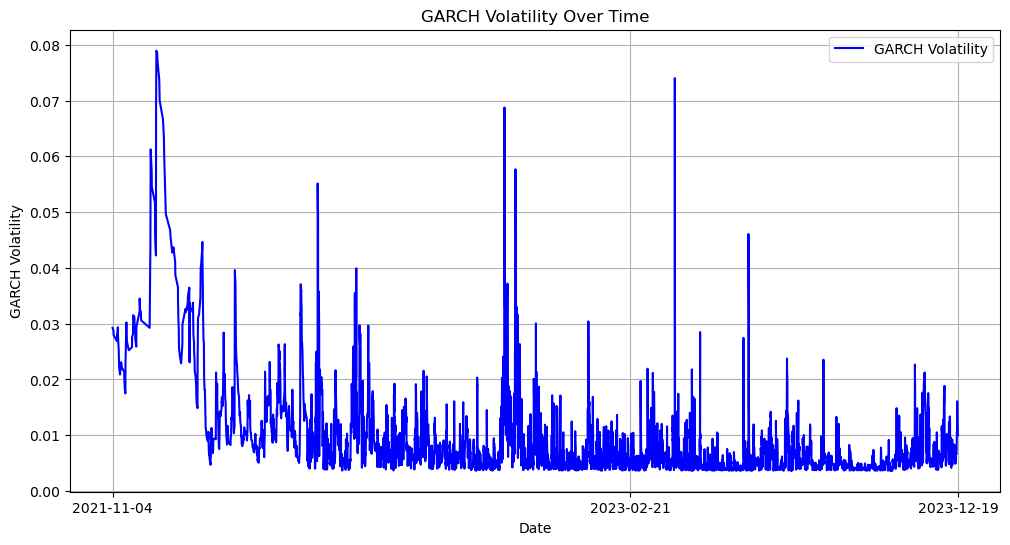

In [92]:
# Convert Date to datetime format with dayfirst=True
intermediate_data['date'] = pd.to_datetime(intermediate_data['date'], dayfirst=True)

# Determine the first, middle, and last date for x-ticks
first_date = intermediate_data['date'].iloc[0]
middle_date = intermediate_data['date'].iloc[len(intermediate_data) // 2]
last_date = intermediate_data['date'].iloc[-1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(intermediate_data['date'], intermediate_data['garch_vol'], label='GARCH Volatility', color='blue')

# Customizing the x-axis ticks
plt.xticks([first_date, middle_date, last_date], 
           [first_date.strftime('%Y-%m-%d'), 
            middle_date.strftime('%Y-%m-%d'), 
            last_date.strftime('%Y-%m-%d')])

# Adding labels, title, and legend
plt.xlabel('Date')
plt.ylabel('GARCH Volatility')
plt.title('GARCH Volatility Over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


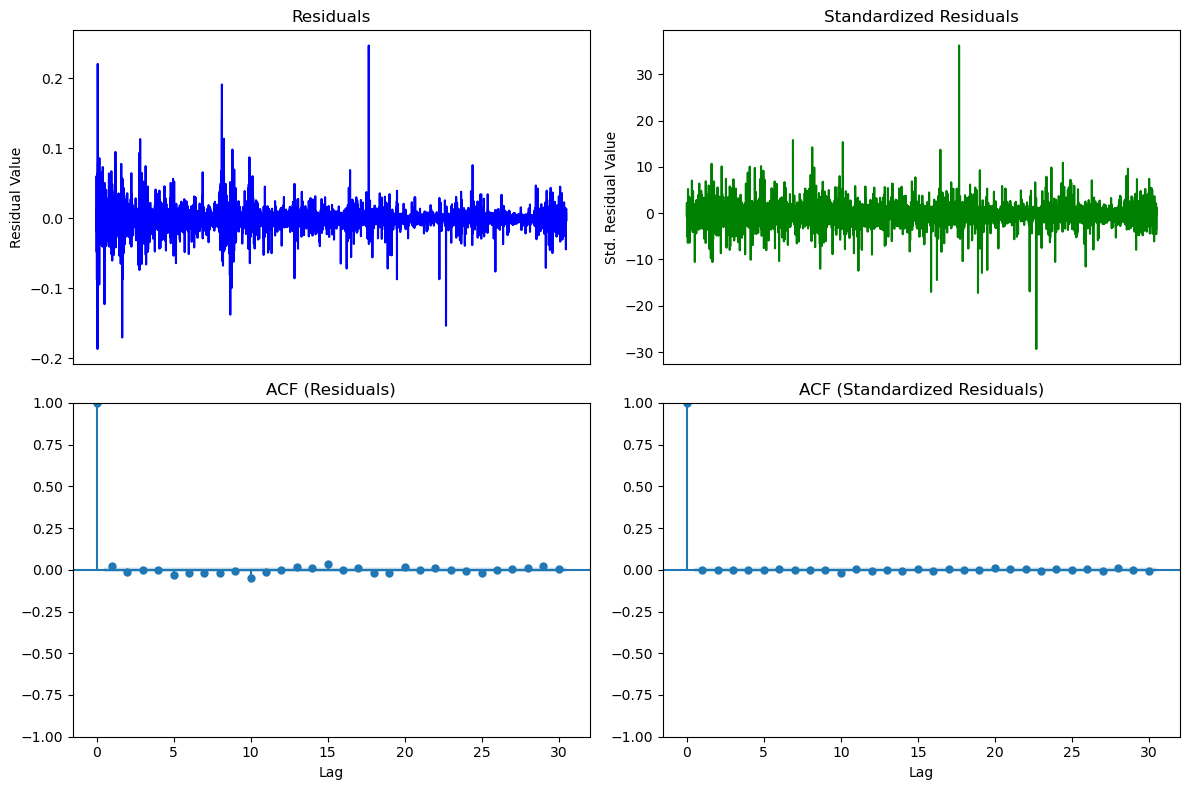

In [93]:
# Extract residuals (epsilon), conditional vol, and standardized residuals
residuals = res.resid
conditional_vol = res.conditional_volatility
standardized_residuals = residuals / conditional_vol

# ----- Plot Setup -----
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Residuals vs time
axes[0, 0].plot(residuals.index, residuals, label='Residuals', color='blue')
axes[0, 0].set_title("Residuals")
axes[0, 0].set_xlabel("")  # Remove x-label
axes[0, 0].set_ylabel("Residual Value")
axes[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks

# 2. Standardized residuals vs time
axes[0, 1].plot(standardized_residuals.index, standardized_residuals, label='Std Residuals', color='green')
axes[0, 1].set_title("Standardized Residuals")
axes[0, 1].set_xlabel("")  # Remove x-label
axes[0, 1].set_ylabel("Std. Residual Value")
axes[0, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks

# 3. ACF of residuals (move this to the bottom-left position)
sm.graphics.tsa.plot_acf(residuals.dropna(), lags=30, ax=axes[1, 0])
axes[1, 0].set_title("ACF (Residuals)")
axes[1, 0].set_xlabel("Lag")  # Add x-label

# 4. ACF of standardized residuals (move this to the bottom-right position)
sm.graphics.tsa.plot_acf(standardized_residuals.dropna(), lags=30, ax=axes[1, 1])
axes[1, 1].set_title("ACF (Standardized Residuals)")
axes[1, 1].set_xlabel("Lag")  # Add x-label

plt.tight_layout()
plt.show()




In [ ]:
#Merged News data
data = read_file("../data/processed/final_df.csv")
data

In [ ]:
#Sentiment data is the tesla news sentiment data
sentiment_data = data[data["Source"] == "Crypto_News"]
sentiment_data.head()

In [ ]:
# Round up 'date' to the nearest minute
sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute

# Make timezones consistent
# Option 2: Add timezone to sentiment_data
sentiment_data['date'] = sentiment_data['date'].dt.tz_localize('UTC')

# Merge the DataFrames on the 'date' key
intermediate_data = pd.merge(
    returns_data,
    sentiment_data,
    on='date',
    how='inner'  # Use 'inner' to keep only matching rows
)

intermediate_data.head()

In [ ]:
write_file(intermediate_data,"../data/processed/input_df_analysis_5(Crypto_News_on_Doge_Volatility).parquet")

In [ ]:
def optimize_params_func(train_set, val_set, initial_params, transformations):
    """
    Example grid search to find best hyperparameters for the strategy,
    picking those that maximize the Sharpe ratio on the validation set.
    Uses Joblib for multithread processing.

    Returns:
      best_params (dict)
      best_val_sharpe (float)
    """
    # Define your search space:
    gamma_values = [0.0003,0.001]
    beta_values = [0.3,0.7]
    delta_values = [5,10]
    lambda_values = [30,60]
    alpha_values = [0.1,0.5]
    
    # Function to evaluate a single combination of parameters
    def evaluate_params(gamma, beta, delta_, lambda_, alpha_):
        # Build transformations for train/val
        current_transformations = [
            (classify_returns, {
                'column_name': 'Log_Return',
                'gamma': gamma
            }),
            (discretize_sentiment_column, {
                'beta': beta
            }),
            (calculate_and_add_transfer_entropy, {
                'source_col': 'Sentiment_Discretized',
                'target_col': 'Return_Label',
                'window_size': lambda_,
                'delta': delta_
            }),
            (apply_trading_strategy, {
                'alpha': alpha_,
                'delta': delta_
            })
        ]

        # (Optional) "Train" on train_set if there's a model to fit;
        # if purely rule-based, we just skip or run the pipeline anyway:
        _ = optimization_pipeline(train_set.copy(), current_transformations)

        # Evaluate on val_set
        val_df = optimization_pipeline(val_set.copy(), current_transformations)
        val_sharpe = calculate_sharpe_ratio(val_df)

        return {
            'gamma': gamma,
            'beta': beta,
            'delta': delta_,
            'lambda': lambda_,
            'alpha': alpha_,
            'val_sharpe': val_sharpe
        }

    # Use Joblib to parallelize the grid search
    results = Parallel(n_jobs=-1)(  # n_jobs=-1 uses all available cores
        delayed(evaluate_params)(gamma, beta, delta_, lambda_, alpha_)
        for gamma in gamma_values
        for beta in beta_values
        for delta_ in delta_values
        for lambda_ in lambda_values
        for alpha_ in alpha_values
    )

    # Find the best parameters based on the Sharpe ratio
    best_result = max(results, key=lambda x: x['val_sharpe'])
    best_params = {k: best_result[k] for k in ['gamma', 'beta', 'delta', 'lambda', 'alpha']}
    best_val_sharpe = best_result['val_sharpe']

    return best_params, best_val_sharpe

In [ ]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.003,
    'beta': 0.3,
    'delta': 5,
    'lambda': 30,
    'alpha': 0.1
}

# Start the timer
start_time = time.time()

summary_df_5 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func
)

# End the timer
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time
print(f"Runtime: {runtime:.2f} seconds")

In [ ]:
summary_df_5

In [ ]:
write_file(summary_df_5, "../data/processed/ESS_summary_df_analysis_5(Crypto_News_on_Doge_Volatility).parquet")